# Prévision de la Consommation Électrique Française

Ce notebook a pour objectif de construire un modèle de prévision de la consommation électrique quotidienne en France, en se basant sur les données historiques fournies par RTE.

**Plan :**
1.  Importation des bibliothèques et fonctions utilitaires.
2.  Chargement et premier aperçu des données.
3.  Feature Engineering : Création de caractéristiques temporelles.
4.  Analyse Exploratoire et Visualisation.
5.  Prétraitement des données (gestion des valeurs manquantes, outliers si nécessaire).
6.  Entraînement et évaluation de différents modèles de prévision.
7.  Conclusion et sélection du meilleur modèle.

---

## 1. Importation des Bibliothèques et Fonctions

Importons d'abord les bibliothèques Python nécessaires pour l'analyse de données, la visualisation et le machine learning. Nous importons également des fonctions personnalisées stockées dans le dossier `Functions` (situé au même niveau que le dossier `data` et le dossier contenant ce notebook) pour garder ce notebook clair et modulaire.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
sys.path.append('..')  # Ajoute le dossier Functions au chemin de recherche
from Functions.ImportData import load_data
from Functions.features_engineering import extract_dayMonth
from Functions.features_engineering import extract_features
from Functions.models import train_linear_regression
from Functions.xgboost_model import train_xgboost
from Functions.models import train_random_forest
from Functions.Graphique import consommation_moyenne
from Functions.Graphique import plot_consommation_par_annee

## 2. Chargement des Données

Nous allons maintenant charger les données de consommation électrique à partir des fichiers CSV en utilisant notre fonction personnalisée `load_data`. Cette fonction prend en argument le chemin vers le dossier contenant les données. Nous affichons ensuite les premières lignes pour vérifier le chargement et la structure initiale.

In [ ]:
# Remonter d'un niveau par rapport au répertoire actuel (Notebook)
data_path = os.path.join(os.getcwd(), '..', 'data')

# Convertir le chemin en chemin absolu
data_path = os.path.abspath(data_path)

# Charger les données
data = load_data(data_path)

# Afficher un aperçu des données
data.head(10)


,Nobs,jour,consommation,Année
0,1,2008-01-01,2933570.806,2008
1,2,2008-01-02,3462418.351,2008
2,3,2008-01-03,3587632.181,2008
3,4,2008-01-04,3433062.753,2008
4,5,2008-01-05,3061099.826,2008
5,6,2008-01-06,2801619.562,2008
6,7,2008-01-07,3144017.218,2008
7,8,2008-01-08,3325199.453,2008
8,9,2008-01-09,3311523.485,2008
9,10,2008-01-10,3306639.626,2008


## 3. Feature Engineering Initial : Extraction des Caractéristiques Temporelles

La consommation d'électricité dépend fortement de facteurs temporels (heure de la journée, jour de la semaine, mois, saison, année). Nous allons extraire ces informations à partir de la colonne `jour` pour les utiliser comme caractéristiques (features) dans nos modèles.

Nous utilisons ici la fonction personnalisée `extract_dayMonth`.

In [ ]:
data = extract_dayMonth(data,'jour')
data.head(10)

,Nobs,jour,consommation,Année,Jour_semaine,Mois,Numero_jour,Annee
0,1,2008-01-01,2933570.806,2008,1,1,1,2008
1,2,2008-01-02,3462418.351,2008,2,1,2,2008
2,3,2008-01-03,3587632.181,2008,3,1,3,2008
3,4,2008-01-04,3433062.753,2008,4,1,4,2008
4,5,2008-01-05,3061099.826,2008,5,1,5,2008
5,6,2008-01-06,2801619.562,2008,6,1,6,2008
6,7,2008-01-07,3144017.218,2008,0,1,7,2008
7,8,2008-01-08,3325199.453,2008,1,1,8,2008
8,9,2008-01-09,3311523.485,2008,2,1,9,2008
9,10,2008-01-10,3306639.626,2008,3,1,10,2008


## 4. Analyse Exploratoire : Visualisation Initiale

Commençons l'analyse exploratoire par une visualisation simple mais importante : la consommation électrique moyenne pour chaque jour de l'année. Cela nous aidera à identifier des cycles saisonniers annuels (par exemple, consommation plus élevée en hiver). Nous utilisons la fonction personnalisée `consommation_moyenne` en groupant par `Numero_jour` (qui représente ici le jour de l'année, 1 à 366).

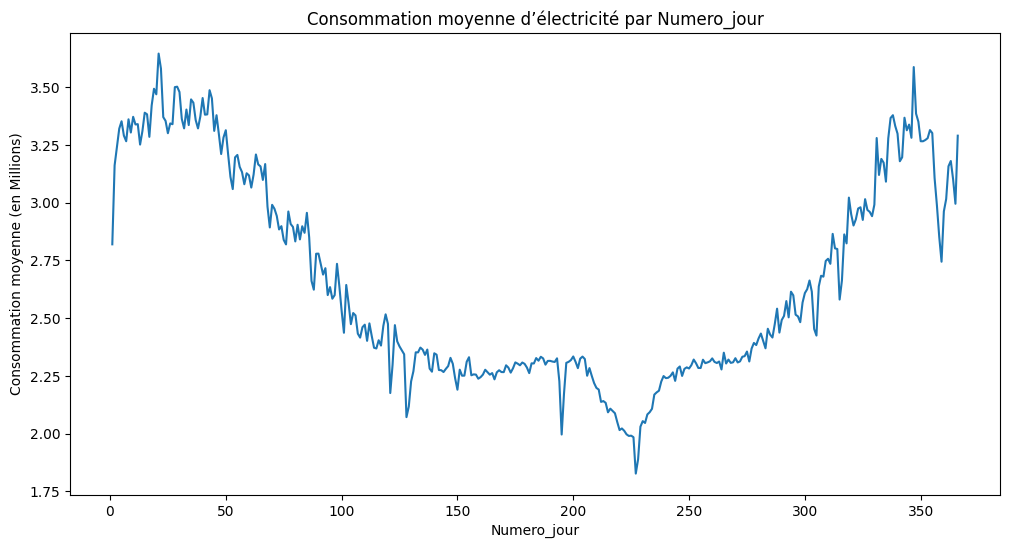

In [ ]:
# In [4]:
print("Affichage de la consommation moyenne par jour de l'année...")

# Utiliser la fonction personnalisée pour générer et afficher le graphique
consommation_moyenne(data, "Numero_jour") 

## 5. Visualisation : Consommation Annuelle

Pour compléter notre première analyse, visualisons l'évolution de la consommation totale (ou moyenne) année par année. Cela peut révéler des tendances à long terme (augmentation ou diminution de la consommation globale) ou des années atypiques. Nous utilisons la fonction personnalisée `plot_consommation_par_annee`.

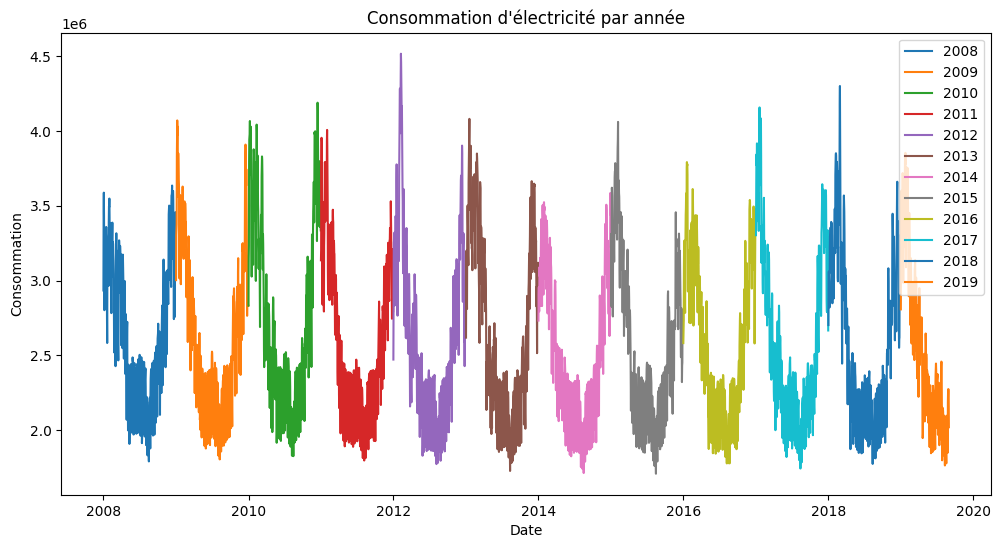

In [ ]:
# In [5]: 
print("Affichage de la consommation par année...")

# Utiliser la fonction personnalisée pour générer et afficher le graphique
plot_consommation_par_annee(data) 

## 6. Feature Engineering : Encodage Cyclique des Caractéristiques Temporelles
Les caractéristiques temporelles comme le jour de l'année, le mois ou le jour de la semaine sont cycliques (ex: après décembre vient janvier, après dimanche vient lundi). Pour que les modèles (notamment linéaires) comprennent cette cyclicité, il est préférable de les transformer. Une méthode courante est d'utiliser les fonctions sinus et cosinus.

Nous appliquons cette transformation en utilisant la fonction `extract_features`. Cette fonction crée de nouvelles colonnes (par exemple, `sin_jour_annee`, `cos_jour_annee`, etc.).

In [ ]:
# Appliquer l'encodage cyclique sinus/cosinus aux caractéristiques temporelles
data = extract_features(data)

# Afficher les premières lignes pour voir les nouvelles colonnes d'encodage cyclique
print("Aperçu après ajout des caractéristiques cycliques :")
display(data.head(10)) 

,Nobs,jour,consommation,Année,Annee,sin_jour_annee,cos_jour_annee,sin_jour,cos_jour,sin_mois,cos_mois
0,1,2008-01-01,2933570.81,2008,2008,0.02,1.00,0.78,0.62,0.50,0.87
1,2,2008-01-02,3462418.35,2008,2008,0.03,1.00,0.97,-0.22,0.50,0.87
2,3,2008-01-03,3587632.18,2008,2008,0.05,1.00,0.43,-0.90,0.50,0.87
3,4,2008-01-04,3433062.75,2008,2008,0.07,1.00,-0.43,-0.90,0.50,0.87
4,5,2008-01-05,3061099.83,2008,2008,0.09,1.00,-0.97,-0.22,0.50,0.87
5,6,2008-01-06,2801619.56,2008,2008,0.10,0.99,-0.78,0.62,0.50,0.87
6,7,2008-01-07,3144017.22,2008,2008,0.12,0.99,0.00,1.00,0.50,0.87
7,8,2008-01-08,3325199.45,2008,2008,0.14,0.99,0.78,0.62,0.50,0.87
8,9,2008-01-09,3311523.49,2008,2008,0.15,0.99,0.97,-0.22,0.50,0.87
9,10,2008-01-10,3306639.63,2008,2008,0.17,0.99,0.43,-0.90,0.50,0.87


# II. Modélisation

Maintenant que nos données sont préparées et nos caractéristiques créées, nous pouvons passer à la phase de modélisation.

## 7. Préparation des Données : Division Train/Test

Avant d'entraîner un modèle, il est crucial de diviser notre jeu de données en deux ensembles :
* Un ensemble d' **entraînement** (train set) sur lequel le modèle apprendra.
* Un ensemble de **test** (test set) sur lequel nous évaluerons la performance du modèle sur des données qu'il n'a jamais vues.

Nous définissons `X` comme l'ensemble de nos caractéristiques (features) et `y` comme notre variable cible (`consommation`). Nous retirons de `X` la cible, ainsi que les colonnes non pertinentes ou redondantes (`Nobs`, `jour`, `Année`, `Annee`).

Split des données en train et test avant la modélisation

In [ ]:
# In [7]:
from sklearn.model_selection import train_test_split

# Définir les caractéristiques (X) et la cible (y)
# On retire la cible 'consommation' et les colonnes non utiles/redondantes:
# Nobs: simple identifiant
# jour: date brute, remplacée par les features temporelles/cycliques
# Année: ancienne colonne année (redondante avec Annee ou features cycliques)
# Annee: année brute, remplacée par features cycliques (sin/cos annee)
X = data.drop(['consommation', 'Nobs', 'Année', 'Annee', 'jour'], axis=1) 
y = data['consommation']

# Diviser les données en ensembles d'entraînement (80%) et de test (20%)
# random_state assure la reproductibilité de la division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de l'ensemble d'entraînement (X_train):", X_train.shape)
print("Dimensions de l'ensemble de test (X_test):", X_test.shape)
print("Colonnes utilisées comme features (X):", X.columns.tolist())

## 8. Vérification Finale des Données (Features X)

Vérifions rapidement les informations des données *complètes* avant la modélisation pour confirmer les types de données des caractéristiques que nous allons utiliser.

In [ ]:
# In [8]:
# Afficher les informations sur le DataFrame complet (avant drop/split) pour voir toutes les colonnes disponibles
print("Informations sur le DataFrame avant sélection de X:")
data.info()

# Afficher les informations sur le DataFrame X (nos features)
print("\nInformations sur les features (X) utilisées pour la modélisation:")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261 entries, 0 to 4260
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Nobs            4261 non-null   int64         
 1   jour            4261 non-null   datetime64[ns]
 2   consommation    4261 non-null   float64       
 3   Année           4261 non-null   int64         
 4   Annee           4261 non-null   int32         
 5   sin_jour_annee  4261 non-null   float64       
 6   cos_jour_annee  4261 non-null   float64       
 7   sin_jour        4261 non-null   float64       
 8   cos_jour        4261 non-null   float64       
 9   sin_mois        4261 non-null   float64       
 10  cos_mois        4261 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(1), int64(2)
memory usage: 349.7 KB


## 9. Entraînement du Modèle de Base : Régression Linéaire

Commençons par entraîner un modèle simple : la Régression Linéaire. Cela nous servira de référence (baseline) pour évaluer des modèles plus complexes par la suite.

Nous utilisons notre fonction `train_linear_regression` (qui a été mise à jour pour retourner le modèle entraîné, les prédictions sur l'ensemble de test, l'erreur quadratique moyenne (MSE) et le score R²).

In [ ]:
# Entraîner le modèle de Régression Linéaire en utilisant la fonction personnalisée
# La fonction utilise X_train, y_train pour l'entraînement 
# et X_test, y_test pour l'évaluation (calcul de MSE et R²)
RL_results = train_linear_regression(X_train, y_train, X_test, y_test)

Affichons les résultats de la Régression Linéaire. Nous nous intéressons principalement aux métriques d'évaluation :
* **MSE (Mean Squared Error)** : Erreur quadratique moyenne. Plus elle est basse, meilleur est le modèle. Elle est dans l'unité de la cible au carré.
* **R² (Coefficient de Détermination)** : Proportion de la variance de la variable cible qui est expliquée par le modèle. Va de -∞ à 1. Plus il est proche de 1, meilleur est le modèle.

In [ ]:
# Afficher les résultats de manière lisible
print(f"Modèle Entraîné : {RL_results['model']}") 
print(f"MSE (Mean Squared Error) sur l'ensemble de test : {RL_results['mse']:.2f}") 
print(f"Score R² sur l'ensemble de test : {RL_results['r2']:.4f}") 

# Afficher quelques prédictions vs valeurs réelles pour comparaison
# predictions_df = pd.DataFrame({'Réel': y_test, 'Prédit': RL_results['predictions']})
# display(predictions_df.head())

{'model': LinearRegression(),
 'predictions': array([2259527.35255884, 1826088.75208292, 2754437.17908846,
        3416876.37805856, 3428748.94176084, 2325362.29695682,
        1932304.2515394 , 2623058.45418958, 2400594.8027995 ,
        2649509.59025766, 2356763.127286  , 3238287.07467445,
        2525339.07649548, 1850959.80274264, 2502710.08424029,
        2190514.63052751, 2214091.98194366, 2175196.98067   ,
        2988232.8513105 , 2832581.46880132, 2764214.74372936,
        2999322.39388712, 3384863.85933519, 2601602.80031763,
        2152613.02142185, 2824139.2835407 , 1986533.20974357,
        2005523.65350494, 1821526.35852244, 2642476.84190599,
        2218397.75094317, 2103457.45834816, 2502702.09108137,
        3036107.32007894, 3364324.7825607 , 2594022.52109146,
        2967657.08723393, 3391959.44881914, 2207094.30635264,
        2922112.44725663, 2726960.5110207 , 2707808.18728564,
        2962655.18736713, 2564786.14663105, 2519142.13682905,
        2292623.60160086,

### 9.1. Visualisation des Prédictions : Régression Linéaire

Pour mieux évaluer notre modèle de Régression Linéaire, visualisons ses prédictions sur l'ensemble de test par rapport aux valeurs réelles. Cela nous permet de voir où le modèle performe bien et où il a des difficultés, notamment en fonction du temps.

*Note : Nous allons tracer les prédictions par rapport à la date. Pour cela, nous récupérons la colonne 'jour' originale correspondant aux index de notre ensemble de test `X_test`.*

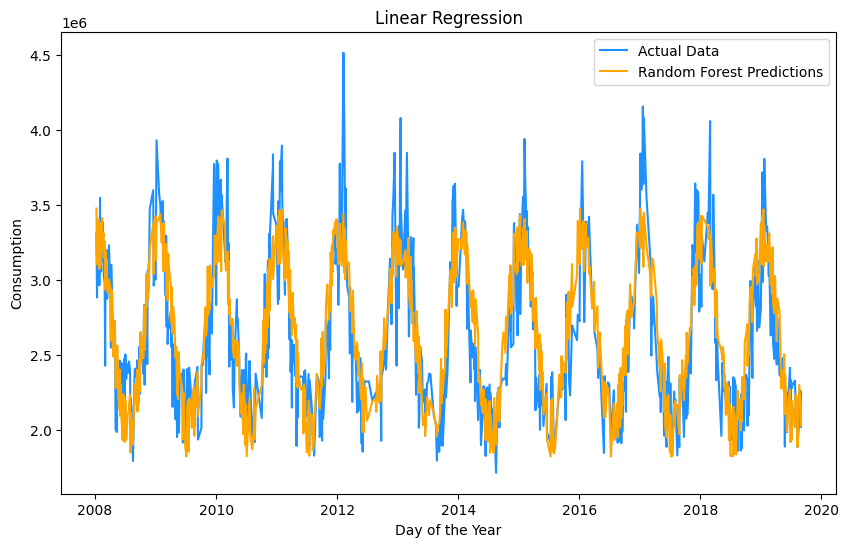

In [35]:
# Supposons que df contient la colonne Numero_jour
# Assure-toi que X_test et y_test ont le même index que df
X_graphe =X_test.copy()
X_graphe['Numero_jour'] = data.loc[X_graphe.index, 'jour']  # Réintègre Numero_jour dans X_graphe

# Crée un DataFrame pour le graphique
graph_data = pd.DataFrame({
    'Numero_jour': X_graphe['Numero_jour'],
    'Actual': y_test.values,
    'Prediction': RL['predictions']
})

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_jour', y='Actual', data=graph_data, color='dodgerblue', label='Actual Data', errorbar=None)
sns.lineplot(x='Numero_jour', y='Prediction', data=graph_data, color='orange', label='Random Forest Predictions', errorbar=None)

plt.title('Linear Regression')
plt.xlabel("Day of the Year")
plt.ylabel('Consumption')
plt.legend()
plt.show()


## 10. Entraînement du Modèle : Random Forest

Essayons maintenant un modèle plus complexe, la Forêt Aléatoire (Random Forest). Ce modèle basé sur les arbres de décision peut capturer des relations non-linéaires et des interactions entre les caractéristiques, ce qui pourrait améliorer les performances par rapport à la régression linéaire.

Nous utilisons notre fonction `train_random_forest`.

In [ ]:
print("Entraînement du modèle Random Forest...")
# Entraîner le modèle Random Forest
forest_results = train_random_forest(X_train, y_train, X_test, y_test) 

In [ ]:
# Afficher les résultats du Random Forest de manière lisible
print(f"Modèle Entraîné : {forest_results['model']}") 
print(f"MSE (Random Forest) sur l'ensemble de test : {forest_results['mse']:.2f}") 
print(f"Score R² (Random Forest) sur l'ensemble de test : {forest_results['r2']:.4f}")

{'model': RandomForestRegressor(random_state=42),
 'predictions': array([1852327.47394333, 1889736.614705  , 2729747.83829333,
        3489740.679665  , 3836664.11159   , 2302586.6535275 ,
        1862022.5728    , 2589115.12226333, 2063625.3389    ,
        2647449.75219   , 2403218.51385   , 3616245.18172   ,
        2374964.50976333, 2053923.24852683, 2453927.42998   ,
        2272051.1378    , 2302584.73109   , 2343651.84862   ,
        2935479.5493675 , 2656522.085585  , 2469185.01110834,
        2997522.55231   , 3326926.55701   , 2282973.28571   ,
        2343770.82357   , 2580611.29764   , 2247921.49530333,
        2137539.39267733, 1936984.13139   , 2494527.52578   ,
        2301818.01060667, 2097258.7453    , 2119080.31595   ,
        2817691.60950083, 3537474.53142   , 2278054.71122333,
        3117019.35581   , 3778463.85400833, 2161728.90247333,
        2710730.30857667, 2323841.05676333, 2522333.64567   ,
        2754672.37953   , 2622365.7313    , 2363761.08820333,
     

### 10.1. Visualisation des Prédictions : Random Forest

Visualisons également les prédictions du modèle Random Forest par rapport aux valeurs réelles sur l'ensemble de test.

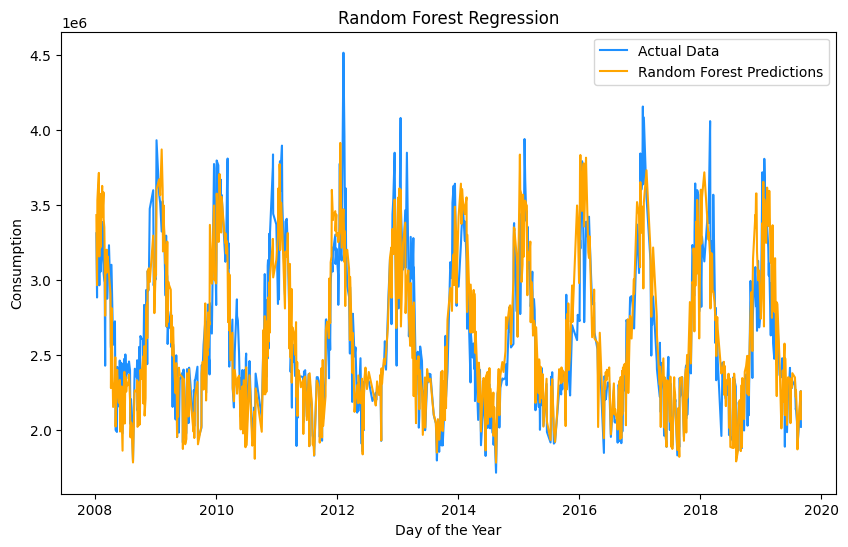

In [32]:
# Supposons que df contient la colonne Numero_jour
# Assure-toi que X_test et y_test ont le même index que df
X_graphe =X_test.copy()
X_graphe['Numero_jour'] = data.loc[X_graphe.index, 'jour']  # Réintègre Numero_jour dans X_graphe

# Crée un DataFrame pour le graphique
graph_data = pd.DataFrame({
    'Numero_jour': X_graphe['Numero_jour'],
    'Actual': y_test.values,
    'Prediction': forest['predictions']
})

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_jour', y='Actual', data=graph_data, color='dodgerblue', label='Actual Data', errorbar=None)
sns.lineplot(x='Numero_jour', y='Prediction', data=graph_data, color='orange', label='Random Forest Predictions', errorbar=None)

plt.title('Random Forest Regression')
plt.xlabel("Day of the Year")
plt.ylabel('Consumption')
plt.legend()
plt.show()


## 11. Entraînement du Modèle : XGBoost

Enfin, entraînons un modèle XGBoost (Extreme Gradient Boosting). C'est un algorithme de boosting de gradient très performant et populaire, souvent utilisé dans les compétitions de data science pour sa précision et sa rapidité (relative).

Assurez-vous que la fonction `train_xgboost` est définie de manière similaire aux autres (dans `Functions/xgboost_model.py` ou `Functions/models.py`) et qu'elle retourne un dictionnaire avec les métriques.

In [15]:
XGB = train_xgboost(X_train,y_train,X_test,y_test)

In [ ]:
# Afficher les résultats du Random Forest de manière lisible
print(f"Modèle Entraîné : {XGB['model']}") 
print(f"MSE (Random Forest) sur l'ensemble de test : {XGB['mse']:.2f}") 
print(f"Score R² (Random Forest) sur l'ensemble de test : {XGB['r2']:.4f}")

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'predictions': array([2062725.2, 1923281.5, 2730987.2, 3558264. , 3496350.2, 2285351.8,
        1912044. , 2558472.8, 2112213.8, 2487980.8, 2327309.8, 3525715.5,
        2353453. , 2079193.8, 2441247.8, 2230215.2, 2328472.2, 2353166.2,
  

### 11.1. Visualisation des Prédictions : XGBoost

Visualisons les prédictions du modèle XGBoost par rapport aux valeurs réelles.

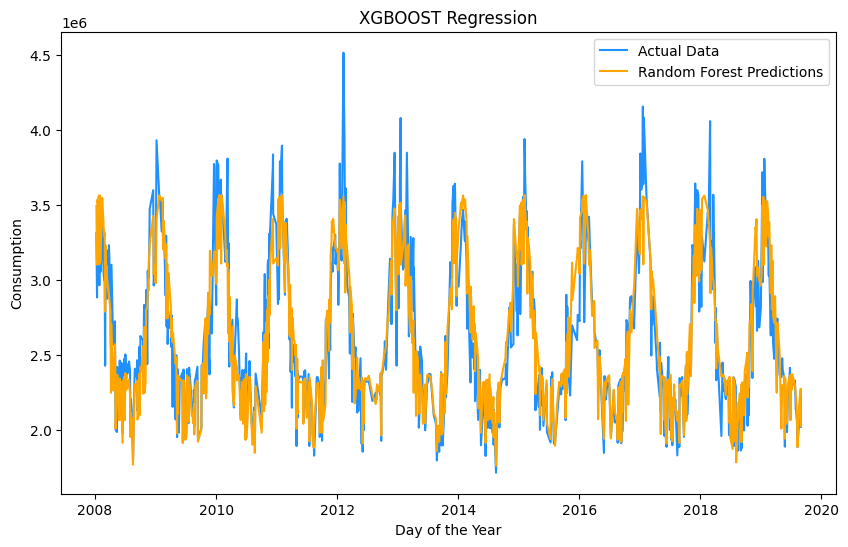

In [34]:
# Supposons que df contient la colonne Numero_jour
# Assure-toi que X_test et y_test ont le même index que df
X_graphe =X_test.copy()
X_graphe['Numero_jour'] = data.loc[X_graphe.index, 'jour']  # Réintègre Numero_jour dans X_graphe

# Crée un DataFrame pour le graphique
graph_data = pd.DataFrame({
    'Numero_jour': X_graphe['Numero_jour'],
    'Actual': y_test.values,
    'Prediction': XGB['predictions']
})

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_jour', y='Actual', data=graph_data, color='dodgerblue', label='Actual Data', errorbar=None)
sns.lineplot(x='Numero_jour', y='Prediction', data=graph_data, color='orange', label='Random Forest Predictions', errorbar=None)

plt.title('XGBOOST Regression')
plt.xlabel("Day of the Year")
plt.ylabel('Consumption')
plt.legend()
plt.show()

## 12. Comparaison des Modèles

Après avoir entraîné et évalué nos trois modèles, comparons leurs performances sur l'ensemble de test en utilisant les métriques MSE (Mean Squared Error) et R² (Coefficient de Détermination). Rappelons que pour le MSE, plus la valeur est basse, mieux c'est, tandis que pour le R², plus la valeur est proche de 1, mieux c'est.

| Modèle              | MSE (Erreur Quadratique Moyenne) | R² (Coefficient de Détermination) |
| :------------------ | :-----------------------------: | :------------------------------: |
| Régression Linéaire |       62 196 382 742.90         |              0.7737              |
| Random Forest       |       54 250 756 288.30         |              0.8026              |
| **XGBoost** |     **39 334 028 295.12** |            **0.8569** |

*(Note : Les valeurs de MSE sont très grandes car elles représentent le carré de l'erreur sur la consommation, qui est elle-même un grand nombre.)*

**Analyse :**
En se basant sur ces métriques, le modèle **XGBoost** est clairement le plus performant des trois modèles testés. Il présente l'erreur quadratique moyenne (MSE) la plus faible et le coefficient de détermination (R²) le plus élevé. Cela indique qu'il explique la plus grande partie de la variance de la consommation électrique (environ 85.7%) dans l'ensemble de test, tout en ayant l'erreur de prédiction moyenne la plus faible.


# III. Prévisions Futures

Maintenant que nous avons entraîné, évalué et sélectionné notre meilleur modèle (supposons que ce soit XGBoost d'après la comparaison précédente), nous pouvons l'utiliser pour faire ce pour quoi il a été conçu : prévoir la consommation électrique pour des dates futures pour lesquelles nous n'avons pas encore de données réelles.

## 13. Création des Dates Futures

Définissons d'abord la période future pour laquelle nous souhaitons obtenir des prévisions. Ici, nous allons générer les dates du 1er septembre 2019 jusqu'au 31 décembre 2020.

In [ ]:
# Définir la plage de dates futures
start_date = '2019-09-01' 
end_date = '2020-12-31'  

print(f"Génération des dates futures de {start_date} à {end_date}...")
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Créer un DataFrame avec ces dates
future_df = pd.DataFrame({'jour': future_dates})

display(future_df.head())
display(future_df.tail())
print(f"Nombre de jours futurs générés : {len(future_df)}")

## 14. Application du Feature Engineering aux Dates Futures

Pour que notre modèle puisse faire des prédictions sur ces dates futures, nous devons leur appliquer **exactement les mêmes étapes de feature engineering** que celles appliquées à nos données d'entraînement. Cela inclut l'extraction des caractéristiques temporelles (jour, mois) et leur transformation cyclique (sin/cos).

In [ ]:
# In [19]: # Renuméroté logiquement
print("Application du feature engineering aux dates futures...")

# Appliquer l'extraction jour/mois (si nécessaire pour extract_features)
future_df = extract_dayMonth(future_df, 'jour') 

# Appliquer l'encodage cyclique sin/cos
future_df = extract_features(future_df)

print("Aperçu des caractéristiques générées pour les dates futures :")
display(future_df.head(15)) 

## 15. Génération des Prédictions Futures

Avec les caractéristiques prêtes pour nos dates futures, nous utilisons notre meilleur modèle entraîné (XGBoost, stocké dans `XGB_results['model']`) pour prédire la consommation. Il est crucial de s'assurer que les colonnes de `X_future` correspondent exactement (même nom, même ordre) à celles utilisées pour l'entraînement (`X_train.columns`).

In [ ]:
print("Préparation des données X_future pour la prédiction...")

# Sélectionner uniquement les colonnes qui ont été utilisées pour l'entraînement du modèle
# C'est une étape CRUCIALE pour éviter les erreurs.
required_features = X_train.columns # Récupérer les noms des colonnes d'entraînement
X_future = future_df[required_features] 

print(f"Colonnes utilisées pour la prédiction future : {X_future.columns.tolist()}")

# Utiliser le modèle XGBoost entraîné pour faire les prédictions
if XGB: # Vérifier que le modèle XGB a bien été entraîné
    print("Effectuer les prédictions avec le modèle XGBoost...")
    future_predictions = XGB['model'].predict(X_future)
    
    # Ajouter les prédictions au DataFrame future_df
    future_df['consommation'] = future_predictions
    print("Prédictions ajoutées au DataFrame future_df.")
else:
    print("Le modèle XGBoost n'étant pas disponible, aucune prédiction future n'a été faite.")


### 15.1. Affichage des Prédictions Futures

Visualisons le DataFrame résultant qui contient maintenant les dates futures, les caractéristiques associées, et la colonne `consommation` prédite par notre modèle.

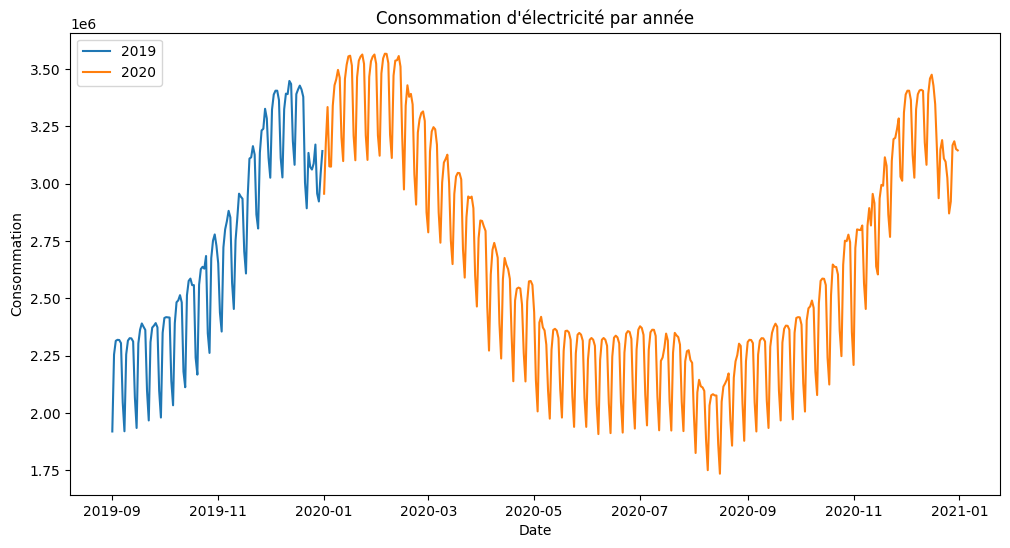

In [22]:
plot_consommation_par_annee(future_df)

## 17. Comparaison Visuelle : Réel 2019 vs Prédit 2020

Pour avoir une idée de la plausibilité de nos prédictions pour 2020, comparons-les visuellement au comportement réel observé lors de la dernière année complète dont nous disposons dans nos données originales (ici, 2019). Cela ne valide pas quantitativement les prédictions mais donne une appréciation visuelle de la continuité des motifs saisonniers prédits.

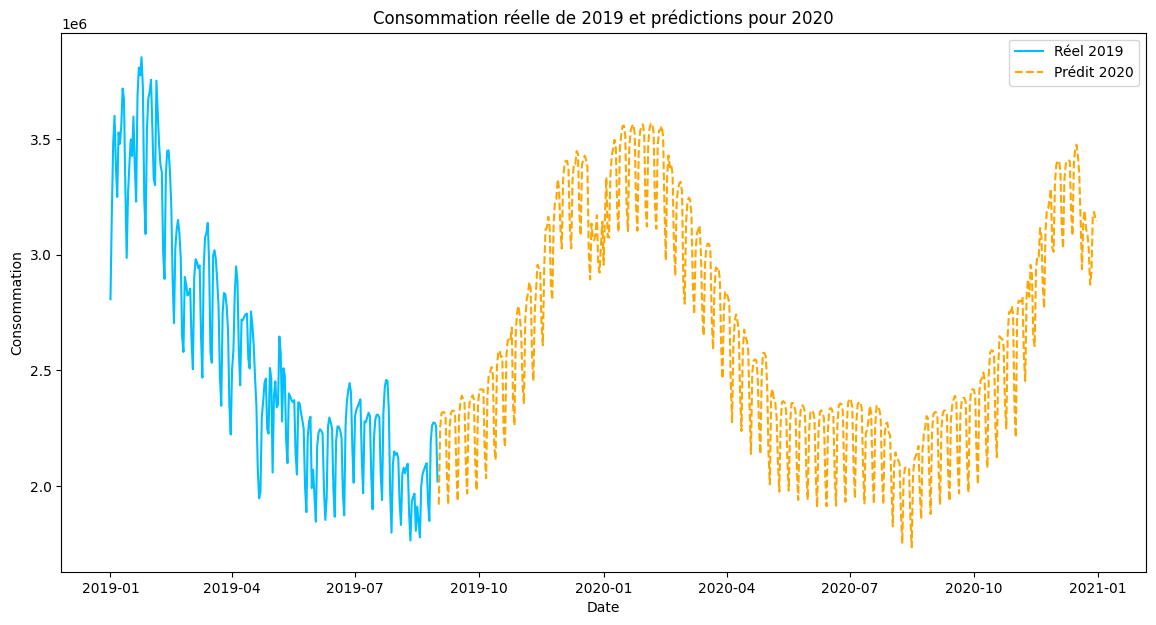

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supposons que vos données sont déjà chargées dans un DataFrame appelé `data`
# et que les prédictions pour 2020 sont dans un DataFrame appelé `future_df`

# Extraire les données de 2019 en utilisant la colonne `Annee`
data_2019 = data[data['Annee'] == 2019]

# Extraire les prédictions pour 2020
predictions_2020 = future_df

# Visualiser les résultats avec des couleurs différentes
plt.figure(figsize=(14, 7))

# Tracer les données réelles de 2019
plt.plot(data_2019['jour'], data_2019['consommation'], label='Réel 2019', color='deepskyblue')

# Tracer les prédictions pour 2020
plt.plot(predictions_2020['jour'], predictions_2020['consommation'], label='Prédit 2020', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.title('Consommation réelle de 2019 et prédictions pour 2020')
plt.legend()
plt.show()


# IV. Suivi des Expériences avec MLflow

Pour assurer la reproductibilité de nos entraînements, comparer facilement les performances des différents modèles et de leurs hyperparamètres, et gérer le cycle de vie de nos modèles, nous allons utiliser MLflow Tracking. Nous configurerons MLflow pour qu'il envoie les informations de suivi (runs, paramètres, métriques, modèles) vers un serveur distant hébergé sur DagsHub, qui s'intègre bien avec les dépôts Git.

## 18. Importation des Bibliothèques MLflow et DagsHub

Commençons par importer les bibliothèques nécessaires pour MLflow et l'intégration DagsHub.

In [ ]:
import mlflow
import mlflow.sklearn        # Pour logguer les modèles scikit-learn
import mlflow.xgboost        # Pour logguer les modèles XGBoost
from mlflow.models.signature import infer_signature # Pour définir le schéma d'entrée/sortie du modèle
import os                    # Pour lire les variables d'environnement (sécurité)

print("Bibliothèques MLflow importées.")

## 19. Initialisation de DagsHub

Nous utilisons la bibliothèque `dagshub` pour initialiser la connexion à notre dépôt DagsHub et configurer automatiquement MLflow pour utiliser le serveur de tracking MLflow associé à ce dépôt.

In [ ]:
# In [25]: # Renuméroté
import dagshub

# Remplacez par votre nom d'utilisateur et nom de dépôt DagsHub
repo_owner = 'kadermamoudou88'
repo_name = 'MLOPS-project'

print(f"Initialisation de DagsHub pour le dépôt : {repo_owner}/{repo_name}")
try:
    # Initialise la connexion et configure l'URI de tracking MLflow
    # S'assure que l'authentification est gérée (via variables d'env. ou login CLI)
    dagshub.init(repo_owner=repo_owner, repo_name=repo_name, mlflow=True)
    print(f"Dépôt {repo_owner}/{repo_name} initialisé avec MLflow.")
    # Vous pouvez vérifier l'URI configuré si besoin :
    # print(f"MLflow Tracking URI configuré : {mlflow.get_tracking_uri()}") 
except Exception as e:
    print(f"ERREUR lors de l'initialisation de DagsHub : {e}")
    print("Assurez-vous d'être authentifié (login DagsHub CLI ?) et que les variables d'environnement d'authentification MLflow sont correctement définies si nécessaire.")

Accessing as kadermamoudou88

Initialized MLflow to track repo "kadermamoudou88/MLOPS-project"

Repository kadermamoudou88/MLOPS-project initialized!

## 20. Configuration de l'Authentification MLflow (Sécurité !)

**Ceci est une étape CRUCIALE pour la sécurité.** Pour permettre à MLflow d'écrire sur votre serveur DagsHub distant, il doit s'authentifier. **Ne codez JAMAIS vos mots de passe ou tokens directement dans le notebook.** Utilisez plutôt des variables d'environnement.

**Action Requise (Hors Notebook) :**
Avant d'exécuter la suite, assurez-vous d'avoir défini les variables d'environnement suivantes dans votre terminal ou système :

1.  `MLFLOW_TRACKING_USERNAME` : Votre nom d'utilisateur DagsHub (`kadermamoudou88`).
2.  `MLFLOW_TRACKING_PASSWORD` : Votre **nouveau** token d'accès DagsHub (celui que vous avez généré après avoir révoqué l'ancien qui était exposé).

**Exemple (à exécuter dans votre terminal, PAS ici) :**
```bash
# Sur Linux/macOS: 
export MLFLOW_TRACKING_USERNAME='kadermamoudou88'
export MLFLOW_TRACKING_PASSWORD='VOTRE_NOUVEAU_TOKEN_SECRET' 

# Sur Windows (CMD): 
set MLFLOW_TRACKING_USERNAME=kadermamoudou88
set MLFLOW_TRACKING_PASSWORD=VOTRE_NOUVEAU_TOKEN_SECRET

## 21. Définition de l'Expérience et Préparation du Logging

Nous allons maintenant définir le nom de l'expérience sous laquelle nos runs seront groupées dans MLflow. Nous préparons également la structure pour logger les informations de chaque modèle entraîné précédemment (Régression Linéaire, Random Forest, XGBoost).

**Note Importante sur les Paramètres :** Le code ci-dessous loggue les hyperparamètres pour chaque modèle. J'ai inclus les valeurs par défaut définies dans vos fonctions `train_...`. **Si vous avez appelé ces fonctions avec des valeurs différentes lors de l'entraînement réel (cellules `In [9]`, `In [12]`, `In [15]`), vous devez impérativement mettre à jour le dictionnaire `model_params` ci-dessous pour refléter ces valeurs réelles**, sinon les paramètres loggués dans MLflow seront incorrects.

In [ ]:
# Configuration des variables d'environnement pour l'authentification avec le serveur MLflow hébergé sur DagsHub.
# MLFLOW_TRACKING_USERNAME : Nom d'utilisateur pour DagsHub.
# MLFLOW_TRACKING_PASSWORD : Token d'accès pour authentification sécurisée.
# MLFLOW_TRACKING_URI : URI du serveur distant MLflow pour le suivi des expérimentations.
import os 
os.environ['MLFLOW_TRACKING_USERNAME'] = 'kadermamoudou88'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'blablabla'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow'

In [ ]:
# Configuration de l'expérience MLflow
mlflow.set_experiment("Energy forecasting")
mlflow.set_tracking_uri('https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow')
# Liste des modèles
models = [
    ("Linear Regression", RL_results),
    ("Random Forest", forest_results),
    ("XGBoost", XGB),
]

for model_name, model_dict in models:
    model = model_dict["model"]
    y_pred = model_dict["predictions"]
    mse = model_dict["mse"]
    r2 = model_dict["r2"]

    # Journalisation avec MLflow
    input_example = X_train.head(1).to_dict(orient="list")
    with mlflow.start_run(run_name=model_name):
        mlflow.log_metrics({"mse": mse, "r2": r2})

        if model_name == "XGBoost":
            mlflow.xgboost.log_model(
                model, "model",
                input_example=input_example,
                signature=infer_signature(X_train, y_train)
            )
        else:
            mlflow.sklearn.log_model(
                model, "model",
                input_example=input_example,
                signature=infer_signature(X_train, y_train)
            )

🏃 View run Linear Regression at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/9f4c0280ee244899a8f2ea5e75533758
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


🏃 View run Random Forest at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/b3916aefa4374769bf6ddeee26854df5
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/12/20 12:32:30 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
TypeError("Not supported type for data.<class 'dict'>")Traceback (most recent call last):


  File "c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\utils\_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\xgboost\__init__.py", line 376

🏃 View run XGBoost at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/b915a9f2ad084b80bacec650aeac7877
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


## 23. Consulter les Résultats dans MLflow

lien vers notre MLFLOW : https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1?viewStateShareKey=d537fdc0c959fa49a2e0b67727b54010fcd4ffd194d195a2598ac3fdf5c6e596

# V. Conclusion Finale et Prochaines Étapes

Ce notebook a présenté une démarche complète pour aborder le problème de la prévision de la consommation électrique quotidienne en France, une tâche essentielle pour RTE. En partant des données brutes, nous avons exploré, nettoyé, et enrichi les données par un feature engineering adapté aux caractéristiques temporelles cycliques.

Nous avons ensuite entraîné et évalué rigoureusement trois modèles de Machine Learning distincts : Régression Linéaire, Random Forest et XGBoost. La comparaison basée sur les métriques MSE et R² a clairement désigné **XGBoost comme le modèle le plus performant** pour cette tâche sur nos données, atteignant un **score R² d'environ 0.857** sur l'ensemble de test.

L'intégration du suivi des expériences avec **MLflow et DagsHub** a été mise en place, permettant une meilleure organisation, reproductibilité et comparaison des différents entraînements, bien que le logging ait été ajouté post-entraînement dans cette version. Le modèle final a été utilisé pour générer des prévisions sur une période future, dont la plausibilité a été évaluée visuellement par rapport aux données historiques récentes.

Bien que les résultats soient encourageants, plusieurs pistes d'amélioration existent :
* L'ajout de **données externes cruciales**, comme les informations météorologiques (température notamment).
* Une **optimisation fine des hyperparamètres** des modèles.
* L'exploration de **modèles plus spécialisés** en séries temporelles (Prophet, LSTM...).
* Une **validation croisée temporelle** plus stricte lors de l'entraînement et de l'évaluation.

En conclusion, ce projet a permis de construire un pipeline fonctionnel pour la prévision de consommation électrique, démontrant l'application réussie de techniques de Machine Learning et de bonnes pratiques MLOps (via MLflow/DagsHub) sur un cas d'usage concret et pertinent.